# What is lost when intentionally removing  'difficult' data?

I believe that the presense of this more difficult data is one of the primary reasons the FracFocus data are rarely used: they are considered too complex to deal with or too dirty to trust.

In this Proof-of-Concept version, I intentionally filter data in the raw FracFocus download that requires a lot of assumptions or complex decisions.  
While in other versions of this code I have tried to grapple with the complexity and inherent inconsistencies of the whole FracFocus set, I hope to show in this version that filtering much of the difficult data still leaves us with a very useful data set.  However, it is important to investigate to what degree this filtering obscures or biases the actual fracking practice.  

In this notebook, I try to show the types and quantities of data that I remove from the raw data to make processing 'simple.'  I try to examine the major sources of filtering: removing 'empty' events, removing events with duplicates, removing chemical records that are poorly identified, and ignoring records in which the carrier is poorly identified.

### Some terminology
What I call 'events' are distinct fracking events that are typically documented by a single disclosure with a list of  chemicals/materials used in the fracturing process (this is separate from the chemicals used to drill the well). These events are identified in the raw data by unique identifier in the UploadKey field.  All records with a given UploadKey will have the same Start and End Dates, location, etc.  If you are familiar with the individual pdf files available at FracFocus.org, each pdf corresponds to one event and one unique UploadKey.

In [42]:
# preamble
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


results_dir = './out/'      # for local use
#results_dir = '../results/' # for CodeOcean

In [28]:
# pull data from the results directory where it is stored as a .csv file
# we don't need all the colunms 
cols = ['UploadKey','date','CASNumber','bgCAS','DQ_code','FFVersion']
df = pd.read_csv(results_dir+'full_df.csv') #,usecols=cols) 
df.date = pd.to_datetime(df.date)  # put date back into datetime format
df['year'] = df.date.dt.year
#df.columns

# Removing 'empty' events

## Background
Although FracFocus began recording chemical disclosures in 2011 and making them available through the pdf files that year, most of the chemical records for the events in these early years are not included in the bulk download.  Instead, placeholder records are used for those events.  Included in these placeholders are location data, dates, and often drilling depth and water volumes used but no chemical information.

I flag these events and they are removed from analysis.


## Number of empty events

In [37]:
gb = df[(df.year>2009)&(df.year<2020)].groupby('UploadKey',as_index=False)['date','year','DQ_code','FFVersion'].first() # only need one record from each event
gb['empty_event'] = gb.DQ_code.str.contains('1') # DQ_code of '1' indicates no chemical records
gb['not_empty'] = ~gb.empty_event
print(f'Total number of events: {len(gb)}, number of empty: {gb.empty_event.sum()}')

Total number of events: 159495, number of empty: 43900


## Empty events are largely from 2011 to 2013

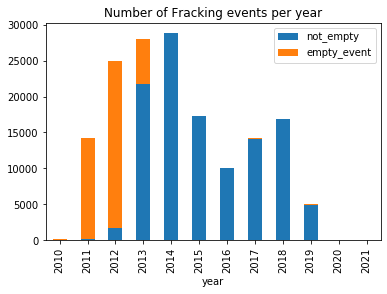

In [38]:
gb2 = gb.groupby('year',as_index=False)['empty_event','not_empty'].sum()
gb2.plot.bar(x='year',y=['not_empty','empty_event'],stacked=True,title="Number of Fracking events per year");


## ... and are FFVersion 1

In [41]:
print('Number of empty events that are:')
for i in [1,2,3]:
    print(f'  FFVersion {i}: {gb[gb.FFVersion==i].empty_event.sum()}')

Number of empty events that are:
  FFVersion 1: 43816
  FFVersion 2: 6
  FFVersion 3: 78


## Possible improvements

The technical manager of FracFocus communicated to me that the chemical data in FFVersion 1 is of lower quality than more recent versions.  That lower quality was the reason they chose to not include it with the bulk download.  Nevertheless, those data cover an important 'boom' time in the fracking industry and may be of interest to many researchers. 

Therefore, be aware that data for many of these early events was scraped from pdfs (through tremdendous effort) by the SkyTruth team during 2011-2013 and are still available at their [website](http://frack.skytruth.org/fracking-chemical-database/frack-chemical-data-download).  In other versions of my code, I have integrated these data. However, for simplicity sake in this Proof-of-Concept version, we process only what is presented by FracFocus in their official bulk download.



# Removing duplicated events

## Background
For a given APINumber, there may be multiple fracking events in the raw data.  Some of these are events that occur on different dates, indicating actual multiple fracks.  However many duplicates in the raw data have the same date.  Because there is more than one possible cause for this duplication (e.g., operators *adding* to a previous disclosure, operators *replacing* a previous disclosure) and no indication in the data which cause, I choose to filter out ALL disclosures related to duplicated events.  

In [63]:
gb = df[(df.year>2009)&(df.year<2020)].groupby(['date','api10'],as_index=False)['DQ_code'].first() # only need one record from each event
print(f'Number of unique API/dates: {len(gb)}')
print(f'Number of unique API/dates involved with duplication: {len(gb[gb.DQ_code.str.contains("2")])}')

gb = df[(df.year>2009)&(df.year<2020)].groupby('UploadKey',as_index=False)['year','DQ_code','FFVersion',
                                                          'bgOperatorName','bgSupplier'].first() # only need one record from each event
gb['dup_event'] = gb.DQ_code.str.contains('2') # DQ_code of '2' indicates one of a duplicated event
gb['not_duplicated'] = ~gb.dup_event
print(f'Total number of duplicates: {gb.dup_event.sum()}')



Number of unique API/dates: 156765
Number of unique API/dates involved with duplication: 2267
Total number of duplicates: 4700


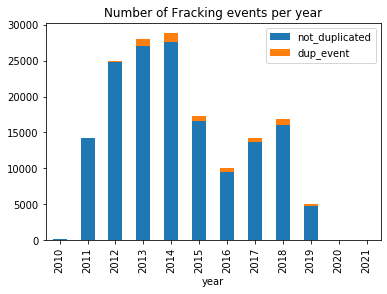

In [50]:
gb2 = gb.groupby('year',as_index=False)['dup_event','not_duplicated'].sum()
gb2.plot.bar(x='year',y=['not_duplicated','dup_event'],stacked=True,title="Number of Fracking events per year");


## are some Operators more likely to submit duplicates?
which might indicate that my filtered set is biased...

In [56]:
gb[gb.dup_event].groupby('bgOperatorName',as_index=False)['UploadKey'].count().sort_values('UploadKey',ascending=False).head(15)

,bgOperatorName,UploadKey
82,devon energy production company l. p.,264
216,pdc energy,164
98,endeavor energy resources,161
67,conocophillips company/burlington resources,149
207,occidental oil and gas,125
65,cog operating llc,116
13,apache corporation,108
147,hunt oil company,106
203,"noble energy, inc.",104
11,anadarko petroleum corporation,103


## ...  or Suppliers?

In [57]:
gb[gb.dup_event].groupby('bgSupplier',as_index=False)['UploadKey'].count().sort_values('UploadKey',ascending=False).head(15)

,bgSupplier,UploadKey
132,no supplier reported,1014
0,_empty_entry_,440
95,halliburton,314
46,chemplex,281
20,baker hughes,210
169,schlumberger,198
137,operator,161
110,liberty,111
129,nabors completion and production services,89
75,economy polymers,75


## Possible improvements
While removing all disclosures related to duplicated events is the simplest to implement, it may be possible to detect which versions are the most recently added (perhaps by the order of records in the raw data).  The technical manager of FracFocus, Mark Layne, indicated to me that there were no clear ways to determine the cause of the duplication.  

# Filtering poorly identified chemical records

## Background
The primary identifier of a chemical material in the raw data is the CAS Registration Number. The FracFocus website points out the while an IngredientName is typically reported on each chemical record, such names are not as reliable as the CAS number.  There are often many synonyms for a given material and are often even spelled in several ways in the raw data.  CAS numbers, however, can be considered an authoritative identification and should apply across the entire data set.  Two examples are 7732-18-5 is water and 91-20-3 is naphthalene.

While the CASNumber field in the raw data is a much more reliable identifier, I have found many issues with its use in FracFocus. These problems include poor formatting (CAS numbers have a strict required format), typographical errors and extraneous characters. For example, some records that are clearly water are mistakenly labled '7332-18-5'.  There are methods to detect and correct these problems (see Possible Improvements below), but for this proof-of-concept version I use a simple approach:  1) Clean the field of extraneous characters, 2) coerce the cleaned CAS number to the proper format (with some simple assumptions) and 3) check this against a catelog of known authoritative CAS numbers.  This catelog was created by running all unique CAS values in the data set through the online resource SciFinder (owned by Chemical Abstracts, the same company that registers CAS numbers).  SciFinder rejects any malformed CAS numbers but provides definitive identity to well-formed numbers.  

So, for this version, a FracFocus CAS number must exactly match (after cleaning) a definitive CAS number to be included in the final data set.  These exact matches are given the authoritative number and names (as bgCAS and bgIngredientName). In the process of categorizing these CAS numbers, I also flag entries of other types:
- proprietary 
- CAS like, but unrecognized
- not CAS-like
- duplicate record due within an event


In [67]:
df['perfect_match'] = df.DQ_code.str.contains('P') # DQ_code of 'P' indicates a perfect match with an authoritative id
df['proprietary'] = df.DQ_code.str.contains('3') # DQ_code of '3' indicates a match with a list of proprietay labels
df['not_kept'] = ~((df.perfect_match)|(df.proprietary))


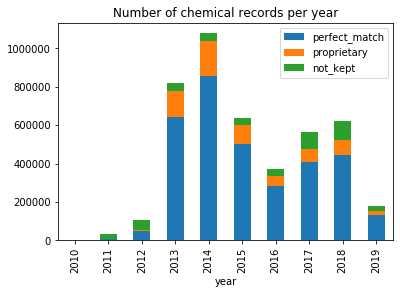

In [70]:
gb2 = df[(df.year>2009)&(df.year<2020)].groupby('year',as_index=False)['perfect_match','proprietary','not_kept'].sum()
gb2.plot.bar(x='year',y=['perfect_match','proprietary','not_kept'],stacked=True,title="Number of chemical records per year");


## Possible improvements
CAS numbers that do not perfectly match the CAS authority can sometimes differ because of a simple typographical error. In a different version of this code, I developed error checking and correcting techniques that integrated both the CASNumber and the given ingredient name.  This involved a combination of automated checking and manual curation and significantly complicated the code.  For many chemical materials, this process improved inclusion by 1-5% and may be useful for specific chemicals of interest that have many labelling problems.  


# Filtering events with poorly identified carriers

## Background
The chemical records that are identified by exact matches to the CAS authority give a broad picture of what chemicals are typically used in the industry, where they are used and by whom.  For these types of questions, simple 'presence/absence' may be enough.  However, more powerful yet are measures of the actual quantities of the chemicals.  The FracFocus data have hooks that allow such calculations and, although the pdf version doesn't provide it, the bulk download version has a MassIngredient field.  Unfortunately, this field reports zeros, or is inconsistent with other numbers or is unused in a large proportion of the data. 

To overcome this major weakness, I calculate mass using simple relationships among the total base water volume, the fraction of that water to the whole fracking mass, and the fraction of individual chemicals in the whole mass.  My calculations align with the reported mass (when available).  However, such calculations are only possible when the data meet the following criteria:
- Water is the principle carrier (sometimes it is a petroleum product)
- The carrier record can be reliably identified and there is only a single record in the event (I require that it is water, and >40% of the total fracking mass).
- The fraction for the carrier is given (as given in PercentHFJob)
- The fraction of the chemical of interest is given.  (also PercentHFJob)


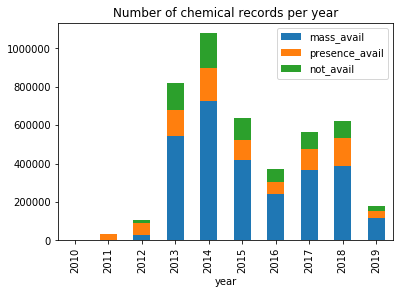

In [72]:
df['mass_avail'] = df.DQ_code.str.contains('M')
df['presence_avail'] = (df.DQ_code.str.contains('A'))&(~df.mass_avail)
df['not_avail'] = ~(df.mass_avail|df.presence_avail)
gb2 = df[(df.year>2009)&(df.year<2020)].groupby('year',as_index=False)['mass_avail','presence_avail','not_avail'].sum()
gb2.plot.bar(x='year',y=['mass_avail','presence_avail','not_avail'],stacked=True,title="Number of chemical records per year");


Note that included in the mass_avail and presence_avail categories are records that are identified as 'Proprietary'.


## Possible improvements
